# Trading Strategies powered by Machine Learning - Classification

## Getting and Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_columns', None)
import pickle as pkl
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
import joblib

# pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_pickle("datasets/multiclass_df.pkl")
params = pkl.load(open("datasets/params.pkl", "rb"))
mu = params["mu"]
std = params["std"]


y_test=pd.read_pickle("datasets/y_test.pkl")
Z_test=pd.read_pickle("datasets/Z_test.pkl")
Z_train=pd.read_pickle("datasets/Z_train.pkl")
y_test=pd.read_pickle("datasets/y_test.pkl")
y_train=pd.read_pickle("datasets/y_train.pkl")

cols = pkl.load(open("datasets/cols.pkl", "rb"))


In [3]:
df.dir_class.value_counts()

-1    55942
 1    55874
 0    37004
Name: dir_class, dtype: int64

In [4]:
split = int(len(df)*0.7)
split

train = df.iloc[:split].copy()
test = df.iloc[split:].copy()

## Predicting Market Direction with Logistic Regression

In [5]:
pos_ratio = y_train.sum()/len(y_train)
pos_ratio

dir_class    0.003053
dtype: float64

In [6]:
class XGBClassifierNew(XGBClassifier()):
    """
      the inherited class with same method name will override.
      if you start an XGBClassifierNew instance the fit method you called by default will be XGBClassifierNew.fit(). Check the link below for reference.
      https://stackoverflow.com/questions/12764995/python-overriding-an-inherited-class-method
      """
    def fit(self, X, y, **kwargs):
        pos_ratio = y.sum() / len(y)
        weight = len(y) / y.sum() - 1
        weight_array = y * (weight - 1) + 1
        return super().fit(X=X, y=y, sample_weight=weight_array, **kwargs)


clf = OneVsRestClassifier(
    XGBClassifier(subsample=0.8,
                  min_child_weight=10,
                  max_depth=3,
                  gamma=5,
                  colsample_bytree=1.0,
                  random_state=42,
                  tree_method='gpu_hist',
                  gpu_id=0))
clf.fit(X=Z_train, y=y_train)

C:\Users\Home\anaconda3\lib\site-packages\xgboost\core.py:568: FutureWarning: Pass `objective, use_label_encoder` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=5, gpu_id=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42,
                                            reg_alpha=None, reg_lambda=None, ...))

In [8]:
 clf = OneVsRestClassifier(XGBClassifier(
#                   subsample=0.8,
#                   min_child_weight=10,
#                   max_depth=3,
#                   gamma=5,
#                   colsample_bytree=1.0,
                  random_state=42,
                  tree_method='gpu_hist',
                  gpu_id=0))

clf.fit(X=Z_train, y=y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=0, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42,
                                            reg_alpha=None, reg_lambda=None, ...))

In [9]:
pkl.dump(clf,open('datasets/ovs_xgb.pkl','wb'))

In [10]:
clf = pkl.load(open('datasets/ovs_xgb.pkl', 'rb'))

In [11]:
train["pred"] = clf.predict(Z_train)

In [12]:
train.pred.value_counts()

-1    38077
 1    37698
 0    28399
Name: pred, dtype: int64

In [13]:
y_train.dir_class.value_counts()

 1    37917
-1    37599
 0    28658
Name: dir_class, dtype: int64

In [14]:
cm = confusion_matrix(y_train, train.pred)
print('Confusion Matrix\n')
print(cm)



print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_train,train.pred)))

print('Micro Precision: {:.4f}'.format(precision_score(y_train, train.pred, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_train, train.pred, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_train, train.pred, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_train, train.pred, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_train, train.pred, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_train, train.pred, average='macro')))

print('Weighted Precision: {:.4f}'.format(precision_score(y_train, train.pred, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_train, train.pred, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_train, train.pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train, train.pred, target_names=['Sell', 'Hold', 'Buy']))

Confusion Matrix

[[24415  6136  7048]
 [ 6407 16041  6210]
 [ 7255  6222 24440]]

Accuracy: 0.6230

Micro Precision: 0.6230
Micro Recall: 0.6230
Micro F1-score: 0.6230

Macro Precision: 0.6181
Macro Recall: 0.6179
Macro F1-score: 0.6180

Weighted Precision: 0.6228
Weighted Recall: 0.6230
Weighted F1-score: 0.6229

Classification Report

              precision    recall  f1-score   support

        Sell       0.64      0.65      0.65     37599
        Hold       0.56      0.56      0.56     28658
         Buy       0.65      0.64      0.65     37917

    accuracy                           0.62    104174
   macro avg       0.62      0.62      0.62    104174
weighted avg       0.62      0.62      0.62    104174



In [16]:

test['pred'] = clf.predict(Z_test)

In [17]:
y_test.value_counts()

dir_class
-1           18343
 1           17957
 0            8346
dtype: int64

In [18]:
test['pred'].value_counts()

 1    22192
-1    19038
 0     3416
Name: pred, dtype: int64

In [19]:
cm = confusion_matrix(y_test, test['pred'])
print('Confusion Matrix\n')
print(cm)



print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, test['pred'])))

print('Micro Precision: {:.4f}'.format(precision_score(y_test, test['pred'], average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_test, test['pred'], average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_test, test['pred'], average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_test, test['pred'], average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_test, test['pred'], average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_test, test['pred'], average='macro')))

print('Weighted Precision: {:.4f}'.format(precision_score(y_test, test['pred'], average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_test, test['pred'], average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_test, test['pred'], average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, test['pred'], target_names=['Sell', 'Hold', 'Buy']))

Confusion Matrix

[[8110 1094 9139]
 [3386 1201 3759]
 [7542 1121 9294]]

Accuracy: 0.4167

Micro Precision: 0.4167
Micro Recall: 0.4167
Micro F1-score: 0.4167

Macro Precision: 0.3988
Macro Recall: 0.3679
Macro F1-score: 0.3670

Weighted Precision: 0.4092
Weighted Recall: 0.4167
Weighted F1-score: 0.4027

Classification Report

              precision    recall  f1-score   support

        Sell       0.43      0.44      0.43     18343
        Hold       0.35      0.14      0.20      8346
         Buy       0.42      0.52      0.46     17957

    accuracy                           0.42     44646
   macro avg       0.40      0.37      0.37     44646
weighted avg       0.41      0.42      0.40     44646



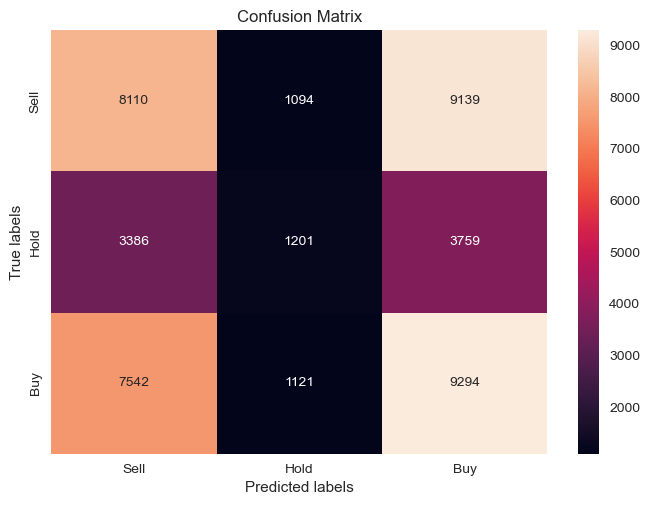

In [20]:
# Plotting the confusion matrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sell','Hold','Buy']); ax.yaxis.set_ticklabels(['Sell','Hold','Buy']);

 Train Accuracy = 0.623  
 Test Accuracy  = 0.4167  
 % diff = 33.11%

## In-Sample Backtesting and the Look-ahead-bias  
  
Test data prediction analysis

In [21]:
train["strategy"] = train.pred * train.returns

In [22]:
train["creturns"] = train["returns"].cumsum().apply(np.exp)
train["cstrategy"] = train["strategy"].cumsum().apply(np.exp)

In [23]:
train

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5,dir_class,pred,strategy,creturns,cstrategy
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01 04:30:00,1.19936,0.000208,1.0,0.001828,1.200007,1.198125,-0.001893,0.000183,0.000022,0.000410,0.0,0.0,0.0,1.0,1.0,0.001834,0.001837,0.001831,0.001830,0.001819,1.200197,1.200351,1.200458,1.200514,1.200565,1.197753,1.197427,1.197126,1.196878,1.196603,-0.001693,-0.001918,-0.002035,-0.002109,-0.002318,0.000392,0.000267,0.000250,0.000175,0.000183,-0.000072,-0.000028,0.000117,0.000114,0.000108,0.000409,0.000407,0.000407,0.000408,0.000424,1,1,0.000208,1.000208,1.000208
2020-09-01 04:35:00,1.19911,-0.000208,-1.0,0.001814,1.199603,1.198691,-0.000284,0.000392,-0.000042,0.000414,1.0,0.0,0.0,0.0,1.0,0.001828,0.001834,0.001837,0.001831,0.001830,1.200007,1.200197,1.200351,1.200458,1.200514,1.198125,1.197753,1.197427,1.197126,1.196878,-0.001893,-0.001693,-0.001918,-0.002035,-0.002109,0.000183,0.000392,0.000267,0.000250,0.000175,0.000022,-0.000072,-0.000028,0.000117,0.000114,0.000410,0.000409,0.000407,0.000407,0.000408,-1,-1,0.000208,1.000000,1.000417
2020-09-01 04:40:00,1.19912,0.000008,1.0,0.001714,1.199595,1.198688,-0.000292,0.000384,0.000003,0.000199,0.0,1.0,0.0,0.0,0.0,0.001814,0.001828,0.001834,0.001837,0.001831,1.199603,1.200007,1.200197,1.200351,1.200458,1.198691,1.198125,1.197753,1.197427,1.197126,-0.000284,-0.001893,-0.001693,-0.001918,-0.002035,0.000392,0.000183,0.000392,0.000267,0.000250,-0.000042,0.000022,-0.000072,-0.000028,0.000117,0.000414,0.000410,0.000409,0.000407,0.000407,0,0,0.000000,1.000008,1.000417
2020-09-01 04:45:00,1.19898,-0.000117,-1.0,0.001609,1.199583,1.198675,-0.000175,0.000500,-0.000106,0.000200,1.0,0.0,1.0,0.0,0.0,0.001714,0.001814,0.001828,0.001834,0.001837,1.199595,1.199603,1.200007,1.200197,1.200351,1.198688,1.198691,1.198125,1.197753,1.197427,-0.000292,-0.000284,-0.001893,-0.001693,-0.001918,0.000384,0.000392,0.000183,0.000392,0.000267,0.000003,-0.000042,0.000022,-0.000072,-0.000028,0.000199,0.000414,0.000410,0.000409,0.000407,-1,-1,0.000117,0.999892,1.000534
2020-09-01 04:50:00,1.19894,-0.000033,-1.0,0.001513,1.199578,1.198688,-0.000142,0.000534,-0.000047,0.000186,0.0,1.0,0.0,1.0,0.0,0.001609,0.001714,0.001814,0.001828,0.001834,1.199583,1.199595,1.199603,1.200007,1.200197,1.198675,1.198688,1.198691,1.198125,1.197753,-0.000175,-0.000292,-0.000284,-0.001893,-0.001693,0.000500,0.000384,0.000392,0.000183,0.000392,-0.000106,0.000003,-0.000042,0.000022,-0.000072,0.000200,0.000199,0.000414,0.000410,0.000409,0,0,-0.000000,0.999858,1.000534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25 15:05:00,1.12708,-0.000035,-1.0,-0.000085,1.127965,1.126686,-0.000266,0.000834,-0.000169,0.000261,0.0,0.0,0.0,1.0,1.0,-0.000101,-0.000142,-0.000164,-0.000185,-0.000210,1.127964,1.127982,1.127973,1.127956,1.127908,1.126692,1.126648,1.126644,1.126648,1.126666,-0.000302,-0.000585,-0.000772,-0.000922,-0.000603,0.000798,0.000514,0.000328,0.000177,0.000497,-0.000207,-0.000006,0.000109,0.000269,0.000160,0.000268,0.000277,0.000277,0.000275,0.000274,0,1,-0.000035,0.939930,2002.180381
2022-01-25 15:10:00,1.12749,0.000364,1.0,-0.000061,1.127977,1.126695,-0.000630,0.000470,0.000015,0.000271,0.0,0.0,0.0,0.0,1.0,-0.000085,-0.000101,-0.000142,-0.000164,-0.000185,1.127965,1.127964,1.127982,1.127973,1.127956,1.126686,1.126692,1.126648,1.126644,1.126648,-0.000266,-0.000302,-0.000585,-0.000772,-0.000922,

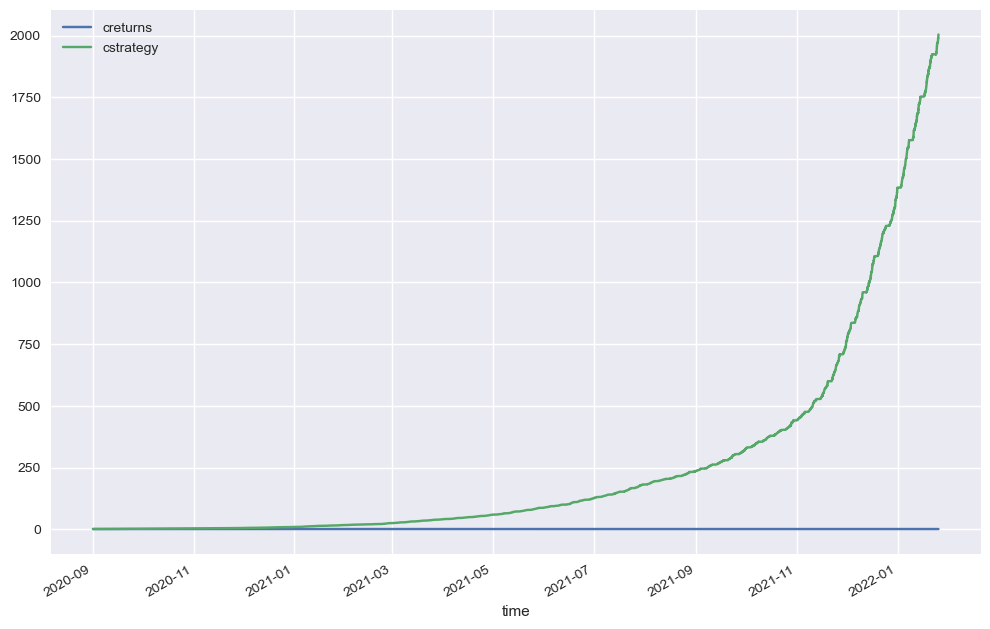

In [24]:
train[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

#### Factoring in a spread of 0.5 basis point

In [25]:
ptc = 0.00005

train["strategy_net"] = train.strategy - abs(train.pred) * ptc
train["cstrategy_net"] = train["strategy_net"].cumsum().apply(np.exp)

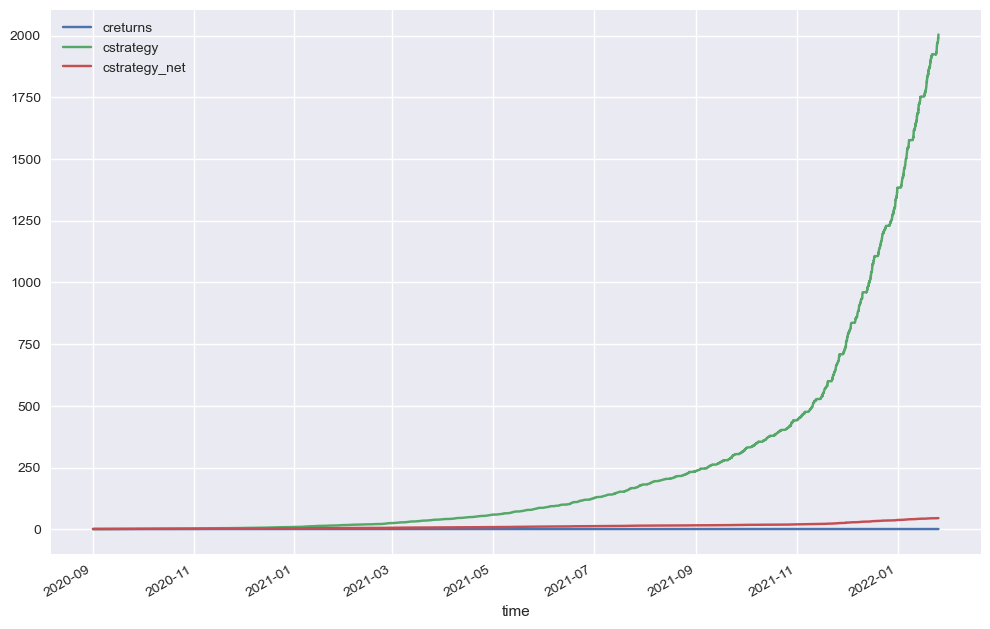

In [26]:
train[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12, 8))
plt.show()

## Out-Sample Forward Testing

In [27]:
test["strategy"] = test.pred * test.returns

In [28]:
test["creturns"] = test["returns"].cumsum().apply(np.exp)
test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)

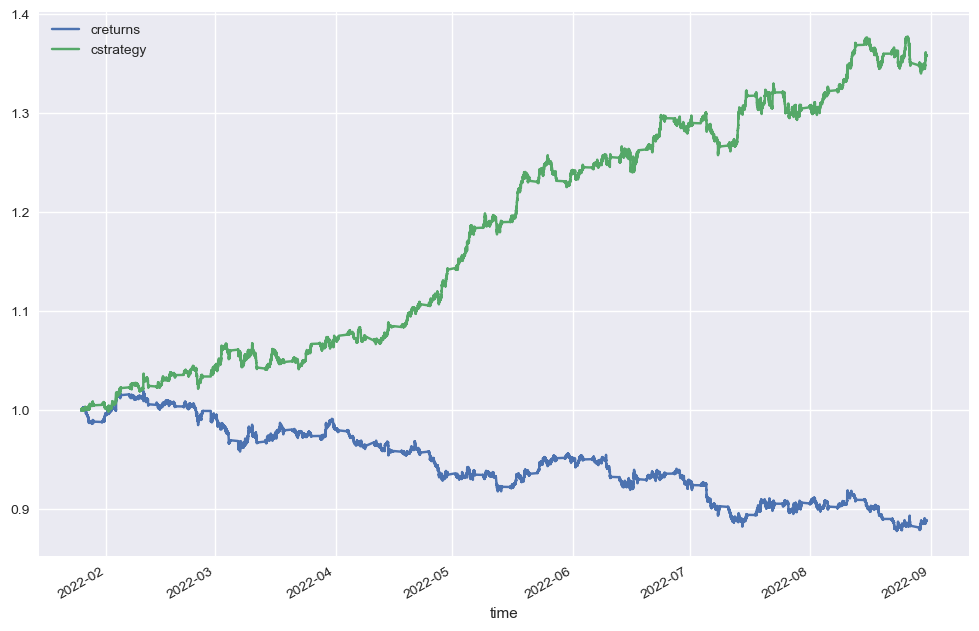

In [29]:
test[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

In [30]:
test["trades"] = test.pred.diff().fillna(0).abs()

In [31]:
test.trades.value_counts()

0.0    27411
2.0    14049
1.0     3186
Name: trades, dtype: int64

In [32]:
test

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5,dir_class,pred,strategy,creturns,cstrategy,trades
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-25 15:30:00,1.12782,-0.000018,-1.0,0.000039,1.128009,1.126762,-0.000807,0.000177,0.000171,0.000263,1.0,1.0,0.0,1.0,0.0,0.000031,0.000008,-0.000022,-0.000061,-0.000085,1.127994,1.127949,1.127954,1.127977,1.127965,1.126768,1.126782,1.126755,1.126695,1.126686,-0.000825,-0.000319,-0.000293,-0.000630,-0.000266,0.000160,0.000665,0.000692,0.000470,0.000834,0.000103,5.618767e-05,3.548679e-05,1.478242e-05,-1.685346e-04,0.000268,0.000259,0.000262,0.000271,0.000261,0,-1,0.000018,0.999982,1.000018,0.0
2022-01-25 15:35:00,1.12754,-0.000248,-1.0,0.000038,1.127995,1.126765,-0.000559,0.000426,0.000080,0.000268,0.0,1.0,1.0,0.0,1.0,0.000039,0.000031,0.000008,-0.000022,-0.000061,1.128009,1.127994,1.127949,1.127954,1.127977,1.126762,1.126768,1.126782,1.126755,1.126695,-0.000807,-0.000825,-0.000319,-0.000293,-0.000630,0.000177,0.000160,0.000665,0.000692,0.000470,0.000171,1.034586e-04,5.618767e-05,3.548679e-05,1.478242e-05,0.000263,0.000268,0.000259,0.000262,0.000271,-1,1,-0.000248,0.999734,0.999769,2.0
2022-01-25 15:40:00,1.12744,-0.000089,-1.0,0.000020,1.127912,1.126801,-0.000470,0.000355,-0.000118,0.000261,0.0,0.0,1.0,1.0,0.0,0.000038,0.000039,0.000031,0.000008,-0.000022,1.127995,1.128009,1.127994,1.127949,1.127954,1.126765,1.126762,1.126768,1.126782,1.126755,-0.000559,-0.000807,-0.000825,-0.000319,-0.000293,0.000426,0.000177,0.000160,0.000665,0.000692,0.000080,1.714662e-04,1.034586e-04,5.618767e-05,3.548679e-05,0.000268,0.000263,0.000268,0.000259,0.000262,-1,1,-0.000089,0.999645,0.999681,0.0
2022-01-25 15:45:00,1.12748,0.000035,1.0,0.000015,1.127896,1.126804,-0.000506,0.000319,-0.000101,0.000252,0.0,0.0,0.0,1.0,1.0,0.000020,0.000038,0.000039,0.000031,0.000008,1.127912,1.127995,1.128009,1.127994,1.127949,1.126801,1.126765,1.126762,1.126768,1.126782,-0.000470,-0.000559,-0.000807,-0.000825,-0.000319,0.000355,0.000426,0.000177,0.000160,0.000665,-0.000118,7.982934e-05,1.714662e-04,1.034586e-04,5.618767e-05,0.000261,0.000268,0.000263,0.000268,0.000259,0,1,0.000035,0.999681,0.999716,0.0
2022-01-25 15:50:00,1.12783,0.000310,1.0,0.000035,1.127950,1.126799,-0.000816,0.000009,0.000086,0.000248,1.0,0.0,0.0,0.0,1.0,0.000015,0.000020,0.000038,0.000039,0.000031,1.127896,1.127912,1.127995,1.128009,1.127994,1.126804,1.126801,1.126765,1.126762,1.126768,-0.000506,-0.000470,-0.000559,-0.000807,-0.000825,0.000319,0.000355,0.000426,0.000177,0.000160,-0.000101,-1.182410e-04,7.982934e-05,1.714662e-04,1.034586e-04,0.000252,0.000261,0.000268,0.000263,0.000268,1,1,0.000310,0.999991,1.000027,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30 23:35:00,1.00218,-0.000140,-1.0,0.000041,1.002333,1.001435,-0.000649,0.000140,0.000013,0.000118,1.0,1.0,1.0,0.0,1.0,0.000017,-0.000015,-0.000052,-0.000090,-0.000131,1.002304,1.002242,1.002202,1.002165,1.002137,1.001421,1.001429,1.001425,1.001419,1.001394,-0.000788,-0.000649,-0.000609,-0.000579,-0.000718,0.000000,0.000000,0.000040,0.000070,0.000000,0.000070,-4.856322e-18,2.328432e-05,7.651402e-05,1.530349e-04,0.000113,0.000111,0.000111,0.000113,0.000113,-1,-1,0.000140,0.888583,1.358278,1.0
2022-08-30 23:40:00,1.00244,0.000259,1.0,0.000066,1.002406,1.001426,-0.000908,0.000000,0.000086,0.000127,0.0,1.0,1.0,1.0,0.0,0.000041,0.000017,-0.000015,-0.000052,-0.000090,1.002333,1.002304,1.0

In [34]:
ptc = 0.000059

In [35]:
test["strategy_net"] = test.strategy - test.trades * ptc

In [36]:
test["cstrategy_net"] = test["strategy_net"].cumsum().apply(np.exp)

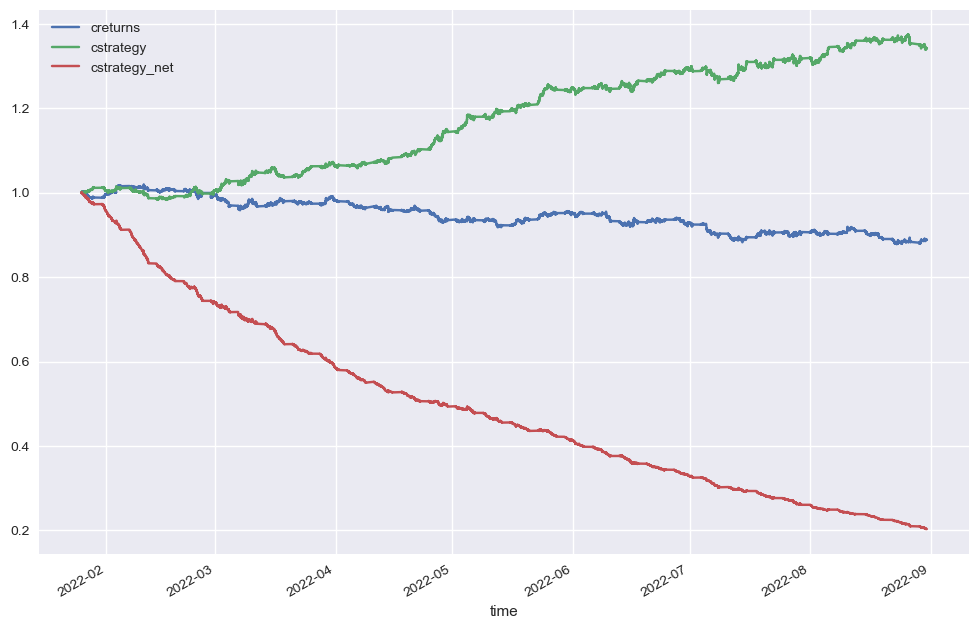

In [37]:
test[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12, 8))
plt.show()